In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
import random

from funcoes_ajuda import descritiva, avalia_clf

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Definir uma semente aleatória para reprodutibilidade
np.random.seed(42)
random.seed(42)

# Gerar as variáveis simuladas com correlação
idade = np.random.randint(18, 71, 10000)

# Gerar variáveis correlacionadas usando a função multivariada normal
mean_values = [5000, 2000, 0.5, 5]  # Médias das variáveis
correlation_matrix = np.array([
    [1, 0.3, 0.2, -0.1],
    [0.3, 1, -0.1, 0.2],
    [0.2, -0.1, 1, 0.4],
    [-0.1, 0.2, 0.4, 1]
])  # Matriz de correlação


In [5]:
# Gerar dados simulados
simulated_data = np.random.multivariate_normal(mean_values, correlation_matrix, 10000)

renda = simulated_data[:, 0]
divida = simulated_data[:, 1]
utilizacao_credito = np.clip(simulated_data[:, 2], 0, 1)  # Limita a utilização de crédito entre 0 e 1
consultas_recentes = np.maximum(simulated_data[:, 3], 0)  # Garante que o número de consultas recentes seja não negativo

# Gerar função linear das variáveis explicativas
preditor_linear = -7 - 0.01 * idade - 0.0002 * renda + 0.003 * divida - 3 * utilizacao_credito + 0.5 * consultas_recentes

# Calcular probabilidade de default (PD) usando a função de link logit
prob_default = 1 / (1 + np.exp(-preditor_linear))

# Gerar inadimplência como variável Bernoulli com base na probabilidade de default
inadimplencia = np.random.binomial(1, prob_default, 10000)

In [6]:
# Criar dataframe
dados = pd.DataFrame({
    'idade': idade,
    'renda': renda,
    'divida': divida,
    'utilizacao_credito': utilizacao_credito,
    'consultas_recentes': consultas_recentes,
    'inadimplencia': inadimplencia
})

print(dados.head())

   idade        renda       divida  utilizacao_credito  consultas_recentes  \
0     56  5001.087921  1999.455126             0.95862            4.875699   
1     69  5000.719625  2000.810295             1.00000            6.445579   
2     46  4999.716997  2001.196934             0.00000            5.101072   
3     32  5001.297920  2000.322691             0.69576            5.748065   
4     60  4999.152684  2000.239878             1.00000            5.304662   

   inadimplencia  
0              0  
1              0  
2              1  
3              0  
4              0  


In [7]:
# Categorizar a idade
kbin = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
dados['idade_cat'] = kbin.fit_transform(dados[['idade']])

def descritiva2(var1, var2, df):
    cross_tab = pd.crosstab(df[var1], df[var2], normalize='index')
    print(cross_tab)

descritiva2('idade_cat', 'inadimplencia', dados)

print(dados.head())

inadimplencia         0         1
idade_cat                        
0.0            0.703339  0.296661
1.0            0.725639  0.274361
2.0            0.752874  0.247126
3.0            0.761631  0.238369
4.0            0.773301  0.226699
   idade        renda       divida  utilizacao_credito  consultas_recentes  \
0     56  5001.087921  1999.455126             0.95862            4.875699   
1     69  5000.719625  2000.810295             1.00000            6.445579   
2     46  4999.716997  2001.196934             0.00000            5.101072   
3     32  5001.297920  2000.322691             0.69576            5.748065   
4     60  4999.152684  2000.239878             1.00000            5.304662   

   inadimplencia  idade_cat  
0              0        3.0  
1              0        4.0  
2              1        2.0  
3              0        1.0  
4              0        4.0  


In [14]:
# dados.to_parquet('/home/usp-ds-arnem/data/exercicio.parquet')

In [8]:
# Ler o dataframe
df = pd.read_parquet('/home/usp-ds-arnem/data/exercicio.parquet')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               10000 non-null  int64  
 1   renda               10000 non-null  float64
 2   divida              10000 non-null  float64
 3   utilizacao_credito  10000 non-null  float64
 4   consultas_recentes  10000 non-null  float64
 5   inadimplencia       10000 non-null  int64  
 6   idade_cat           10000 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 547.0 KB


### Resolução do exercício

In [10]:
y = df['inadimplencia']
X = df.drop('inadimplencia', axis=1)

In [11]:
print(y.shape)
print(X.shape)

(10000,)
(10000, 6)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 6)
(2000, 6)
(8000,)
(2000,)


In [14]:
# Treinando o modelo
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()


Base de treino:
A acurácia da árvore é: 100.0%
A acurácia balanceada da árvore é: 100.0%
AUC-ROC: 100.00%
GINI: 100.00%

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5932
           1       1.00      1.00      1.00      2068

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



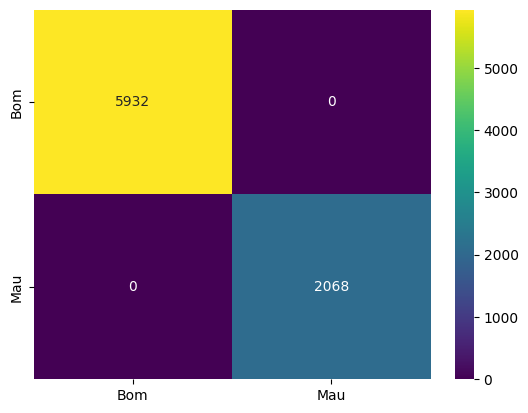

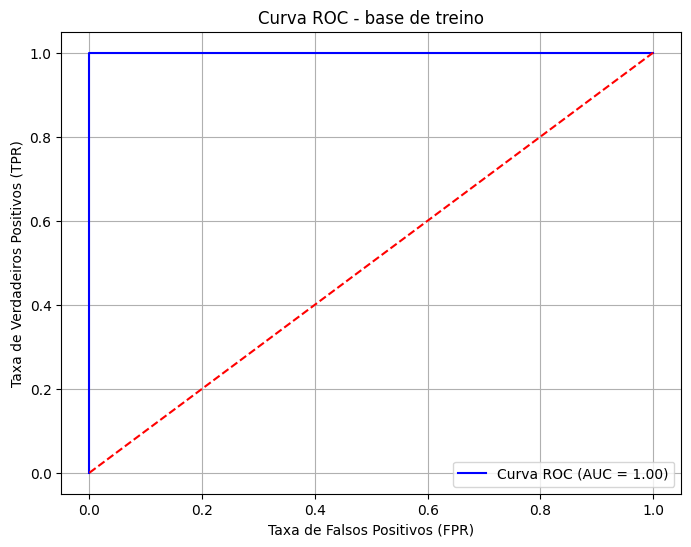

In [15]:
avalia_clf(dtc, y_train, X_train, rótulos_y=['Bom', 'Mau'], base = 'treino')

Bom demais pra ser verdade...rs


Base de teste:
A acurácia da árvore é: 68.4%
A acurácia balanceada da árvore é: 59.9%
AUC-ROC: 59.93%
GINI: 19.87%

               precision    recall  f1-score   support

           0       0.79      0.77      0.78      1484
           1       0.40      0.42      0.41       516

    accuracy                           0.68      2000
   macro avg       0.59      0.60      0.60      2000
weighted avg       0.69      0.68      0.69      2000



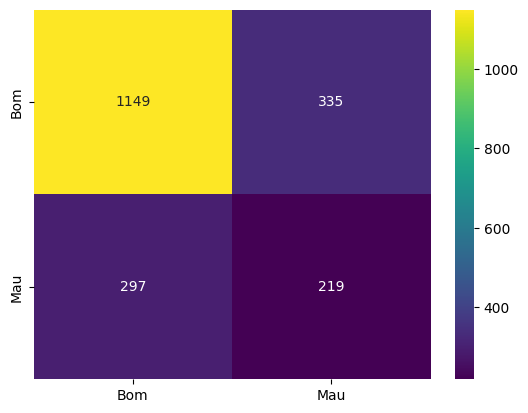

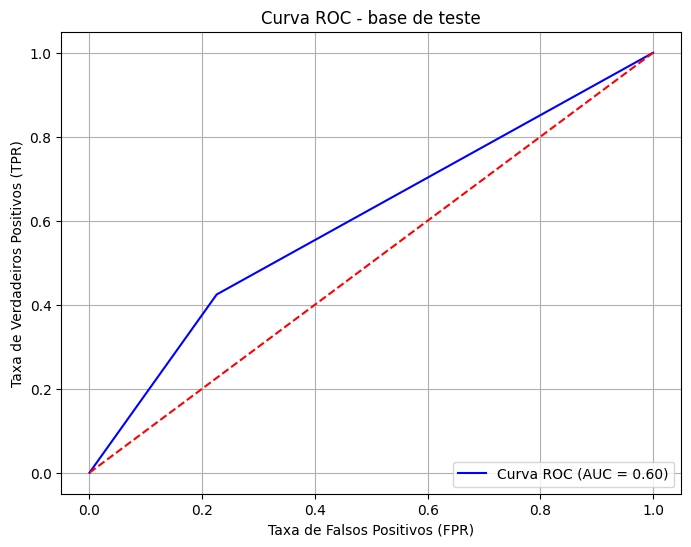

In [16]:
avalia_clf(dtc, y_test, X_test, rótulos_y=['Bom', 'Mau'], base = 'teste')

In [17]:
# Custos de complexidade do modelo
ccp_path = pd.DataFrame(dtc.cost_complexity_pruning_path(X_train, y_train))


In [18]:
ccp_path

,ccp_alphas,impurities
0,0.000000,0.000000
1,0.000062,0.000248
2,0.000076,0.000477
3,0.000078,0.000710
4,0.000081,0.000953
...,...,...
614,0.001845,0.317102
615,0.001861,0.318963
616,0.004060,0.323023
617,0.005868,0.328891


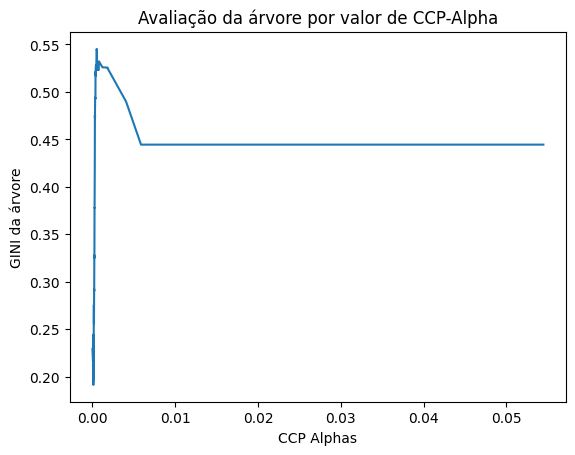

O GINI máximo é de: 54.52%
Obtido com um ccp de: 0.0005200030193236744


In [19]:
GINIs = []

for ccp in ccp_path['ccp_alphas']:
    arvore = DecisionTreeClassifier(criterion='gini', max_depth = 30, 
                                    random_state=42,
                                    ccp_alpha=ccp)

    # Treinar o modelo
    arvore.fit(X_train, y_train)
    AUC = roc_auc_score(y_test, arvore.predict_proba(X_test)[:, -1])
    GINI = (AUC-0.5)*2
    GINIs.append(GINI)

sns.lineplot(x = ccp_path['ccp_alphas'], y = GINIs)

df_avaliacoes = pd.DataFrame({'ccp': ccp_path['ccp_alphas'], 'GINI': GINIs})

GINI_max = df_avaliacoes.GINI.max()
ccp_max  = df_avaliacoes.loc[df_avaliacoes.GINI == GINI_max, 'ccp'].values[0]

plt.ylabel('GINI da árvore')
plt.xlabel('CCP Alphas')
plt.title('Avaliação da árvore por valor de CCP-Alpha')
plt.show()

print(f'O GINI máximo é de: {GINI_max:.2%}\nObtido com um ccp de: {ccp_max}')


Árvore ótima

In [20]:
dtc_optimal = DecisionTreeClassifier(criterion='gini', 
                                     max_depth = 30, 
                                    random_state=42,
                                    ccp_alpha=ccp_max).fit(X_train, y_train)


Avaliando a base de treino:

Base de treino:
A acurácia da árvore é: 77.3%
A acurácia balanceada da árvore é: 66.8%
AUC-ROC: 78.54%
GINI: 57.08%

               precision    recall  f1-score   support

           0       0.82      0.88      0.85      5932
           1       0.58      0.45      0.51      2068

    accuracy                           0.77      8000
   macro avg       0.70      0.67      0.68      8000
weighted avg       0.76      0.77      0.76      8000



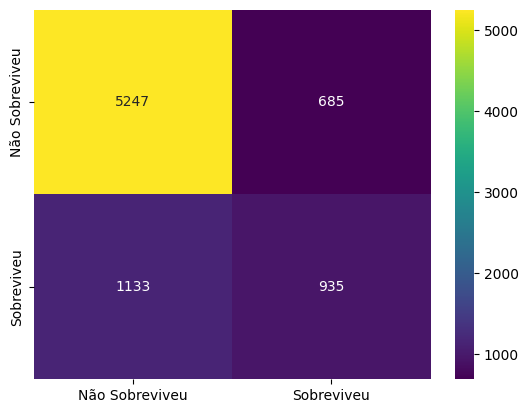

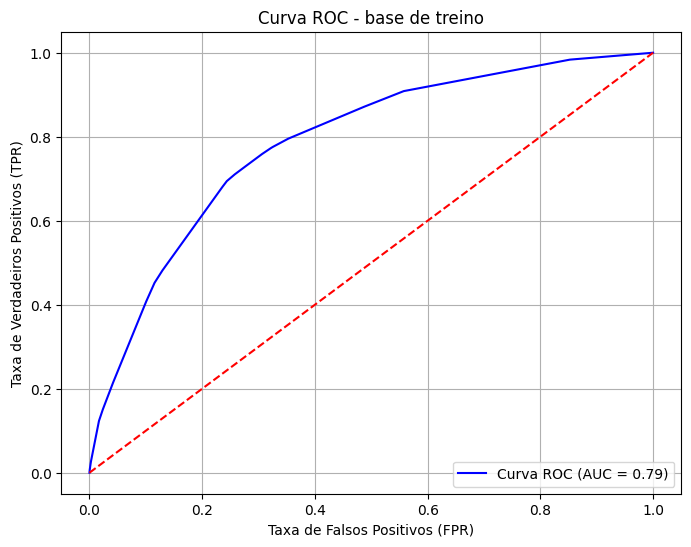

Avaliando a base de teste:

Base de teste:
A acurácia da árvore é: 76.3%
A acurácia balanceada da árvore é: 65.8%
AUC-ROC: 77.26%
GINI: 54.52%

               precision    recall  f1-score   support

           0       0.82      0.88      0.85      1484
           1       0.55      0.44      0.49       516

    accuracy                           0.76      2000
   macro avg       0.68      0.66      0.67      2000
weighted avg       0.75      0.76      0.75      2000



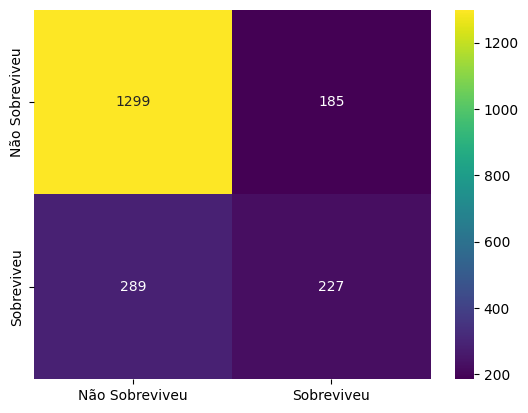

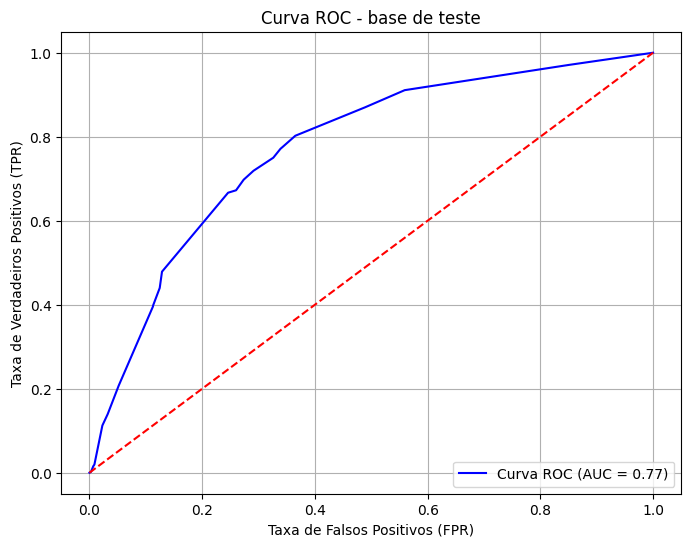

In [21]:
print('Avaliando a base de treino:')
avalia_clf(dtc_optimal, y_train,X_train, base='treino')
print('Avaliando a base de teste:')
avalia_clf(dtc_optimal, y_test,X_test, base='teste')

In [22]:
dtc_optimal.feature_names_in_

array(['idade', 'renda', 'divida', 'utilizacao_credito',
       'consultas_recentes', 'idade_cat'], dtype=object)

In [24]:
from sklearn.tree import export_graphviz

export_graphviz(
        dtc_optimal,
        out_file=str("/home/usp-ds-arnem/images/tree.dot"), 
        feature_names=['idade', 'renda', 'divida', 'utilizacao_credito',
       'consultas_recentes', 'idade_cat'],
        #class_names=iris.target_names,
        rounded=True,
        filled=True
    )

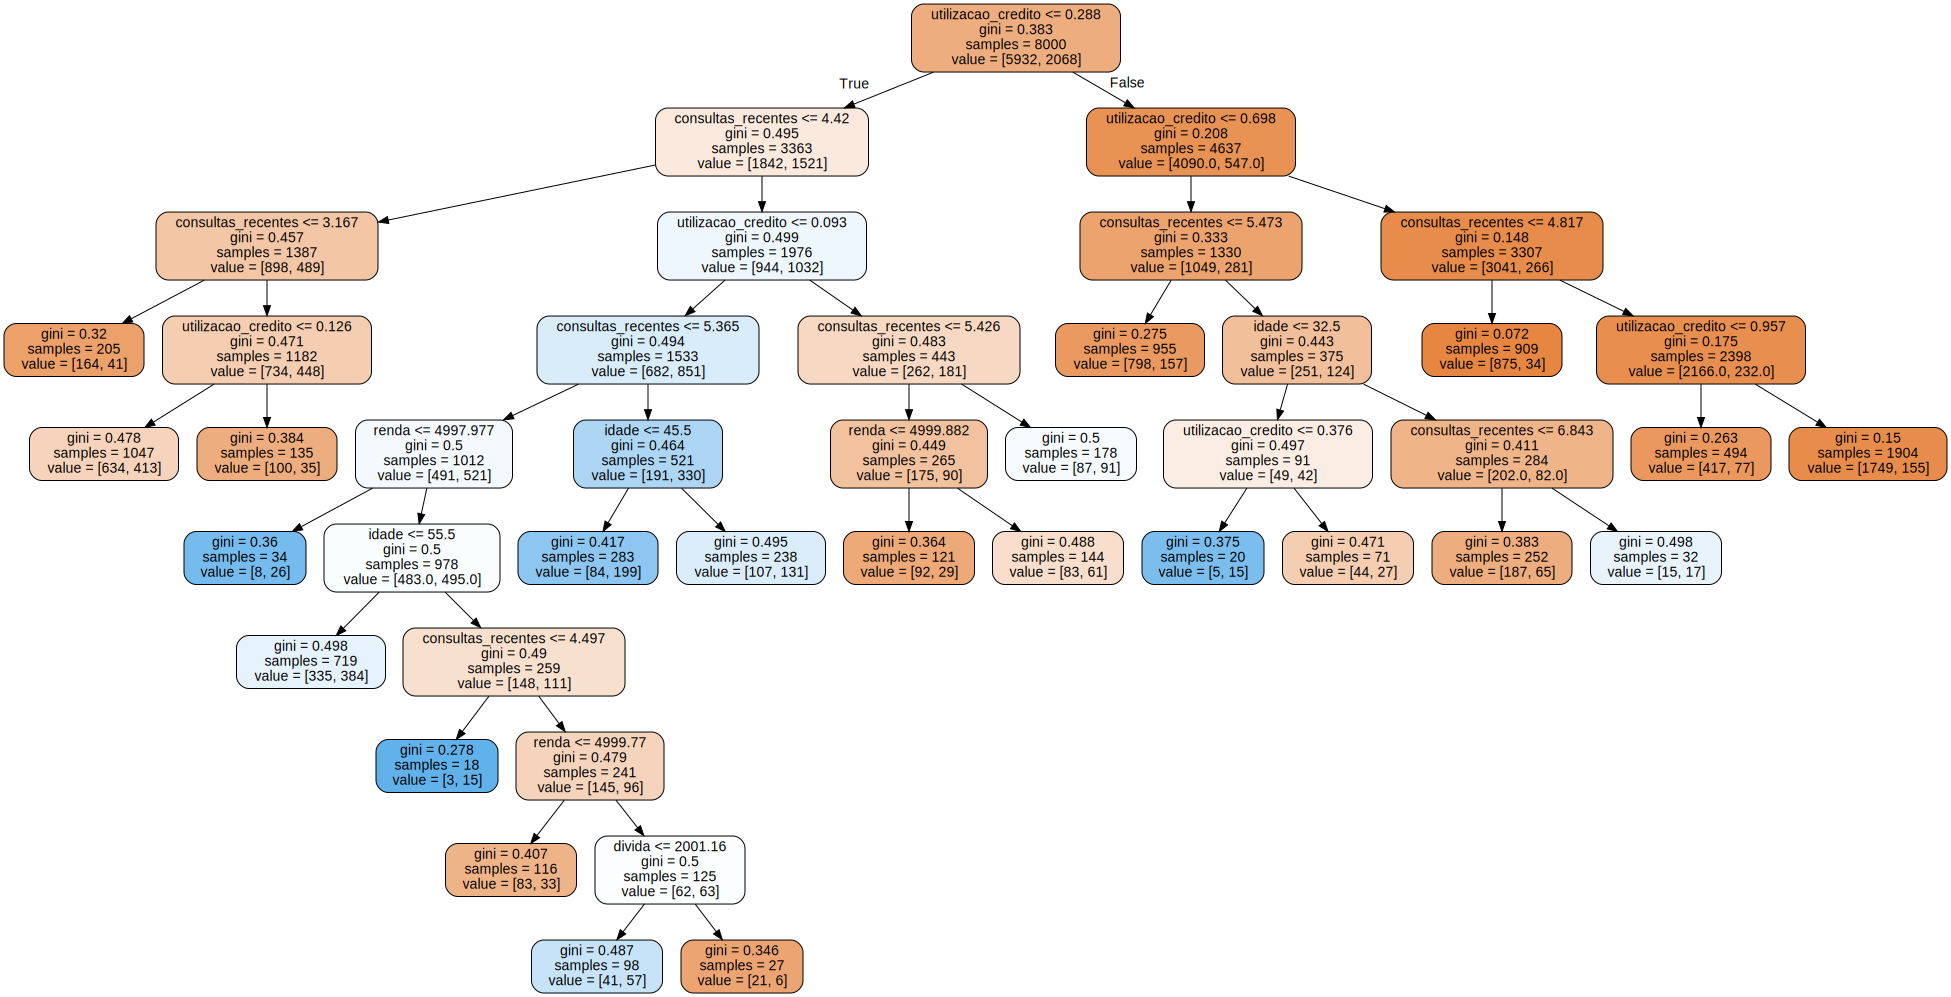

In [28]:
from graphviz import Source

Source.from_file("/home/usp-ds-arnem/images/tree.dot") 